In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas import DataFrame, read_csv
import pandas as pd 
import sys
%matplotlib inline
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Matplotlib version ' + mpl.__version__)

Python version 3.7.2 (default, Jan  3 2019, 09:14:01) 
[GCC 8.2.1 20181215 (Red Hat 8.2.1-6)]
Pandas version 0.24.0
Matplotlib version 3.0.2


In [5]:
filepath = 'output_config2.csv'
df = pd.read_csv(filepath)
df['strategy'] = df['strategy'].map(lambda name : name.split('.')[1].lower())
df['sample'] = df['sample'].map(lambda name : name.split('.')[0])
df.head()

,sample,hardware_type,file_system,strategy,split_time,merge_time,split_nb_seeks,merge_nb_seeks,split_read_time,merge_read_time,split_write_time,merge_write_time,split_seek_time,merge_seek_time
0,bigBrainSample1-0-0,ram,tmpfs,multiple,19.824615,22.493328,3,2806,2.002234,10.891019,13.128618,3.664678,0,0.011331
1,bigBrainSample1-0-0,hdd,ext4,clustered,126.160497,133.058816,2808,2806,66.021195,42.563630,59.998115,81.654337,0,0.017618
2,bigBrainSample1-0-0,ram,tmpfs,naive,56.723534,40.653708,8,3388006,17.244015,2.768173,39.407510,2.865144,0,7.750268
3,bigBrainSample0-0-0,ram,tmpfs,clustered,16.675726,20.791382,2808,2806,3.408970,9.640471,13.089564,3.749887,0,0.011175
4,bigBrainSample0-0-1,hdd,ext4,multiple,126.442074,144.761417,3,2806,48.243311,55.932791,73.563009,80.855036,0,0.017451


In [13]:
tmpfs=df[df['file_system']=='tmpfs']
hdd=df[df['file_system']=='ext4']

# TMPFS

In [56]:
stats=tmpfs.groupby([tmpfs['strategy'],tmpfs['sample']]).mean()
stats

split_time  merge_time  split_nb_seeks  \
strategy  sample                                                        
clustered bigBrainSample0-0-0   16.149808   20.483343            2808   
          bigBrainSample0-0-1   16.253202   20.409799            2808   
          bigBrainSample0-1-0   16.125049   20.626254            2808   
          bigBrainSample0-1-1   16.138574   22.343880            2808   
          bigBrainSample1-0-0   16.094576   22.454817            2808   
multiple  bigBrainSample0-0-0   19.173695   20.190991               3   
          bigBrainSample0-0-1   19.297296   20.376053               3   
          bigBrainSample0-1-0   19.316634   20.388688               3   
          bigBrainSample0-1-1   19.666566   20.317803               3   
          bigBrainSample1-0-0   19.283865   20.588886               3   
naive     bigBrainSample0-0-0   47.393994   36.912711               8   
          bigBrainSample0-0-1   68.020751   39.318471               8   
          bigBrainSample0-1-0   87.667771   45.093722               8   
          bigBrainSample0-1-1  107.241732   46.708608               8   
          bigBrainSample1-0-0   58.645515   38.906647               8   

                               merge_nb_seeks  split_read_time  \
strategy  sample                                                 
clustered bigBrainSample0-0-0            2806         3.200171   
          bigBrainSample0-0-1            2806         3.208255   
          bigBrainSample0-1-0            2806         3.202210   
          bigBrainSample0-1-1            2806         3.145270   
          bigBrainSample1-0-0            2806         3.159285   
multiple  bigBrainSample0-0-0            2806         1.849852   
          bigBrainSample0-0-1            2806         1.883021   
          bigBrainSample0-1-0            2806         1.851869   
          bigBrainSample0-1-1            2806         1.857242   
          bigBrainSample1-0-0            2806         1.857402   
naive     bigBrainSample0-0-0         3388006        16.802038   
          bigBrainSample0-0-1         3388006        16.784766   
          bigBrainSample0-1-0         3388006        16.878275   
          bigBrainSample0-1-1         3388006        16.651725   
          bigBrainSample1-0-0         3388006        17.465317   

                               merge_read_time  split_write_time  \
strategy  sample                                                   
clustered bigBrainSample0-0-0         9.374076         12.784937   
          bigBrainSample0-0-1         9.400725         12.881711   
          bigBrainSample0-1-0         9.366687         12.757670   
          bigBrainSample0-1-1        10.348228         12.834577   
          bigBrainSample1-0-0        10.454251         12.775420   
multiple  bigBrainSample0-0-0         9.363438         12.756691   
          bigBrainSample0-0-1         9.458426         12.821343   
          bigBrainSample0-1-0         9.392751         12.818139   
          bigBrainSample0-1-1         9.347605         12.709944   
          bigBrainSample1-0-0         9.615579         12.787582   
naive     bigBrainSample0-0-0         2.325083         30.521126   
          bigBrainSample0-0-1         2.315787         51.166896   
          bigBrainSample0-1-0         2.351632         70.727779   
          bigBrainSample0-1-1         2.324784         90.530977   
          bigBrainSample1-0-0         2.444247         41.106816   

                               merge_write_time  split_seek_time  \
strategy  sample                                                   
clustered bigBrainSample0-0-0          3.602647                0   
          bigBrainSample0-0-1          3.640325                0   
          bigBrainSample0-1-0          3.599230                0   
          bigBrainSample0-1-1          3.841307                0   
          bigBrainSample1-0-0          3.854436                0   
multiple  bigBrainSample0-0-0    

we can see that the results are the same no matter the input sample:


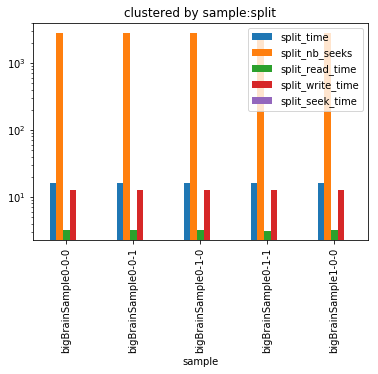

we can therefore do a mean on the sample:


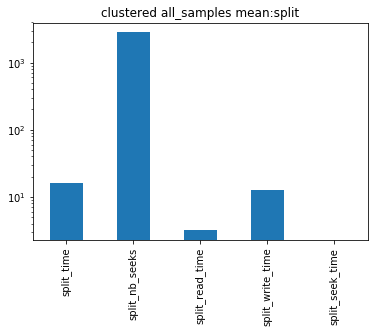

we can see that the results are the same no matter the input sample:


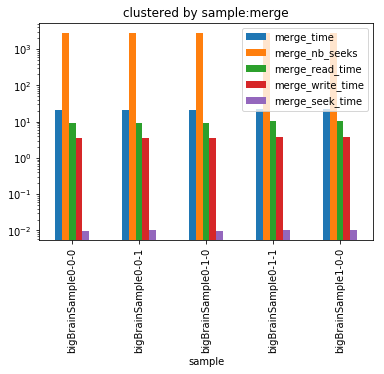

we can therefore do a mean on the sample:


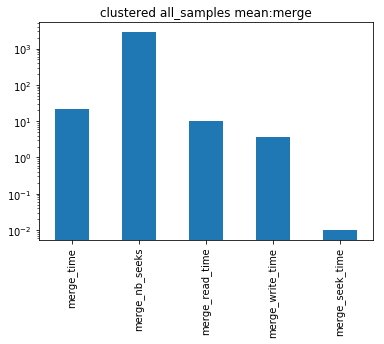

we can see that the results are the same no matter the input sample:


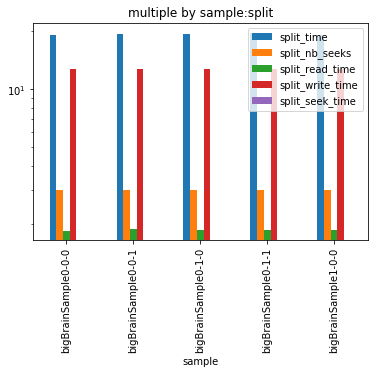

we can therefore do a mean on the sample:


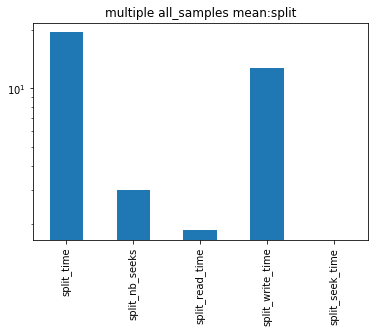

we can see that the results are the same no matter the input sample:


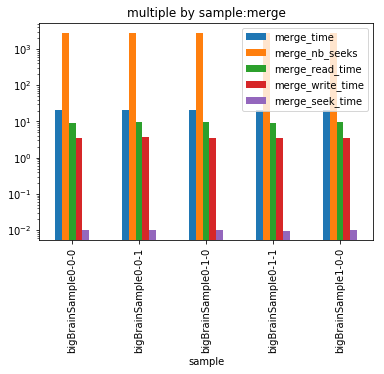

we can therefore do a mean on the sample:


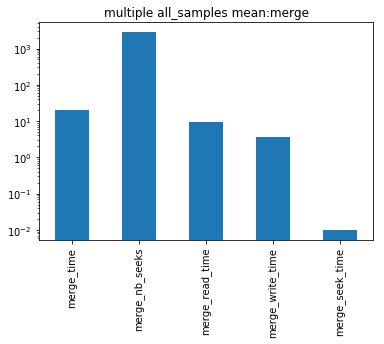

In [85]:
def printInfoByStrategy(tmpfs, strategyName):
    print('we can see that the results are the same no matter the input sample:')
    clustered = tmpfs[tmpfs['strategy']==strategyName]
    clustered_split = clustered.filter(['split_time','split_nb_seeks','split_read_time', 'split_write_time', 'split_seek_time'], axis=1)
    by_sample = clustered_split.groupby(tmpfs['sample']).mean().plot(kind='bar', title=strategyName +' by sample:split')
    by_sample.set_yscale('log')
    plt.show()

    print('we can therefore do a mean on the sample:')
    clustered_split2=DataFrame(clustered_split)
    all_samples = clustered_split2.mean().plot(kind='bar', title=strategyName +' all_samples mean:split')
    all_samples.set_yscale('log')
    plt.show()
    
    print('we can see that the results are the same no matter the input sample:')
    clustered_merge = clustered.filter(['merge_time','merge_nb_seeks','merge_read_time', 'merge_write_time', 'merge_seek_time'], axis=1)
    by_sample = clustered_merge.groupby(tmpfs['sample']).mean().plot(kind='bar', title=strategyName +' by sample:merge')
    by_sample.set_yscale('log')
    plt.show()

    print('we can therefore do a mean on the sample:')
    clustered_merge2=DataFrame(clustered_merge)
    all_samples = clustered_merge2.mean().plot(kind='bar', title=strategyName +' all_samples mean:merge')
    all_samples.set_yscale('log')
    plt.show()
    
printInfoByStrategy(tmpfs, 'clustered')
printInfoByStrategy(tmpfs, 'multiple')


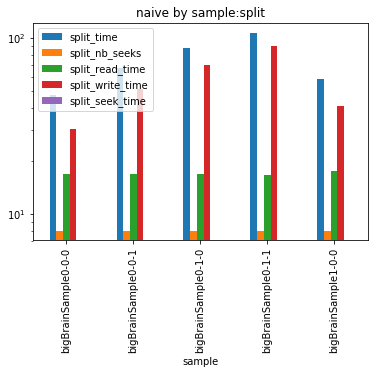

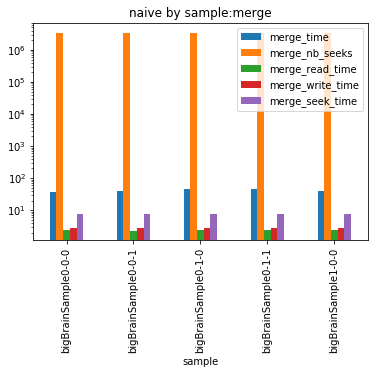

In [87]:
def print_naive(tmpfs):
    #NAIVE
    naive = tmpfs[tmpfs['strategy']=='naive']
    naive_split = naive.filter(['split_time','split_nb_seeks','split_read_time', 'split_write_time', 'split_seek_time'], axis=1)
    by_sample = naive_split.groupby(tmpfs['sample']).mean().plot(kind='bar', title='naive by sample:split')
    by_sample.set_yscale('log')
    plt.show()

    naive_merge = naive.filter(['merge_time','merge_nb_seeks','merge_read_time', 'merge_write_time', 'merge_seek_time'], axis=1)
    by_sample = naive_merge.groupby(tmpfs['sample']).mean().plot(kind='bar', title='naive by sample:merge')
    by_sample.set_yscale('log')
    plt.show()
print_naive(tmpfs)

# HDD

In [84]:
stats=hdd.groupby([hdd['strategy'],hdd['sample']]).mean()
stats

split_time  merge_time  split_nb_seeks  \
strategy  sample                                                        
clustered bigBrainSample0-0-0   16.149808   20.483343            2808   
          bigBrainSample0-0-1   16.253202   20.409799            2808   
          bigBrainSample0-1-0   16.125049   20.626254            2808   
          bigBrainSample0-1-1   16.138574   22.343880            2808   
          bigBrainSample1-0-0   16.094576   22.454817            2808   
multiple  bigBrainSample0-0-0   19.173695   20.190991               3   
          bigBrainSample0-0-1   19.297296   20.376053               3   
          bigBrainSample0-1-0   19.316634   20.388688               3   
          bigBrainSample0-1-1   19.666566   20.317803               3   
          bigBrainSample1-0-0   19.283865   20.588886               3   
naive     bigBrainSample0-0-0   47.393994   36.912711               8   
          bigBrainSample0-0-1   68.020751   39.318471               8   
          bigBrainSample0-1-0   87.667771   45.093722               8   
          bigBrainSample0-1-1  107.241732   46.708608               8   
          bigBrainSample1-0-0   58.645515   38.906647               8   

                               merge_nb_seeks  split_read_time  \
strategy  sample                                                 
clustered bigBrainSample0-0-0            2806         3.200171   
          bigBrainSample0-0-1            2806         3.208255   
          bigBrainSample0-1-0            2806         3.202210   
          bigBrainSample0-1-1            2806         3.145270   
          bigBrainSample1-0-0            2806         3.159285   
multiple  bigBrainSample0-0-0            2806         1.849852   
          bigBrainSample0-0-1            2806         1.883021   
          bigBrainSample0-1-0            2806         1.851869   
          bigBrainSample0-1-1            2806         1.857242   
          bigBrainSample1-0-0            2806         1.857402   
naive     bigBrainSample0-0-0         3388006        16.802038   
          bigBrainSample0-0-1         3388006        16.784766   
          bigBrainSample0-1-0         3388006        16.878275   
          bigBrainSample0-1-1         3388006        16.651725   
          bigBrainSample1-0-0         3388006        17.465317   

                               merge_read_time  split_write_time  \
strategy  sample                                                   
clustered bigBrainSample0-0-0         9.374076         12.784937   
          bigBrainSample0-0-1         9.400725         12.881711   
          bigBrainSample0-1-0         9.366687         12.757670   
          bigBrainSample0-1-1        10.348228         12.834577   
          bigBrainSample1-0-0        10.454251         12.775420   
multiple  bigBrainSample0-0-0         9.363438         12.756691   
          bigBrainSample0-0-1         9.458426         12.821343   
          bigBrainSample0-1-0         9.392751         12.818139   
          bigBrainSample0-1-1         9.347605         12.709944   
          bigBrainSample1-0-0         9.615579         12.787582   
naive     bigBrainSample0-0-0         2.325083         30.521126   
          bigBrainSample0-0-1         2.315787         51.166896   
          bigBrainSample0-1-0         2.351632         70.727779   
          bigBrainSample0-1-1         2.324784         90.530977   
          bigBrainSample1-0-0         2.444247         41.106816   

                               merge_write_time  split_seek_time  \
strategy  sample                                                   
clustered bigBrainSample0-0-0          3.602647                0   
          bigBrainSample0-0-1          3.640325                0   
          bigBrainSample0-1-0          3.599230                0   
          bigBrainSample0-1-1          3.841307                0   
          bigBrainSample1-0-0          3.854436                0   
multiple  bigBrainSample0-0-0    

we can see that the results are the same no matter the input sample:


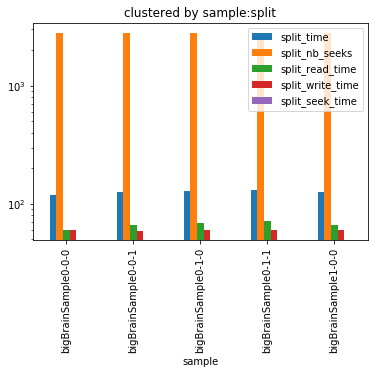

we can therefore do a mean on the sample:


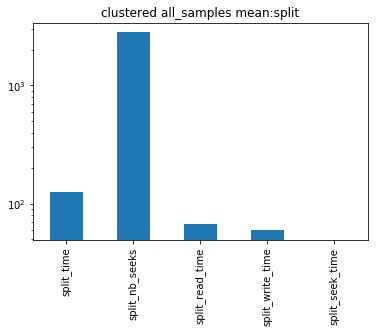

we can see that the results are the same no matter the input sample:


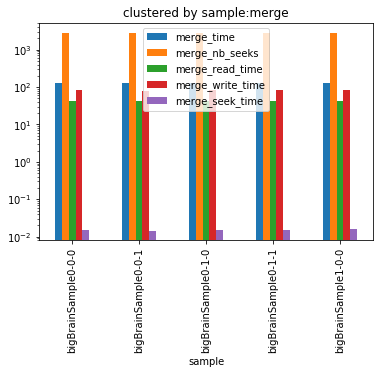

we can therefore do a mean on the sample:


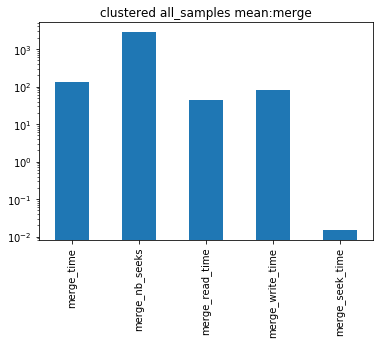

we can see that the results are the same no matter the input sample:


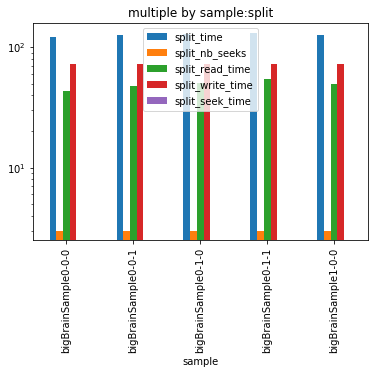

we can therefore do a mean on the sample:


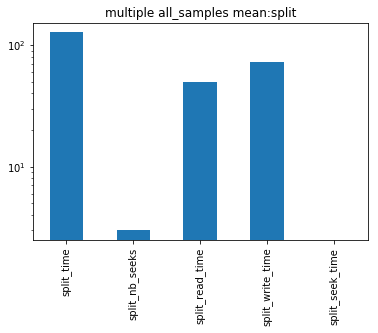

we can see that the results are the same no matter the input sample:


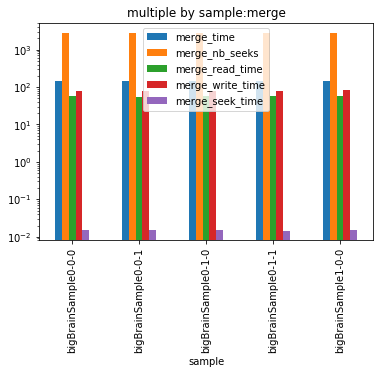

we can therefore do a mean on the sample:


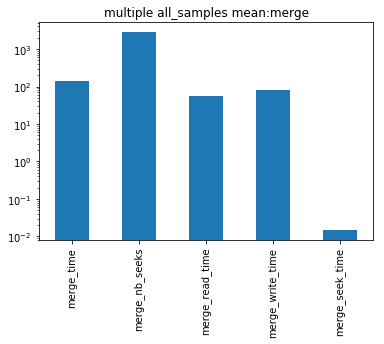

In [86]:
printInfoByStrategy(hdd, 'clustered')
printInfoByStrategy(hdd, 'multiple')

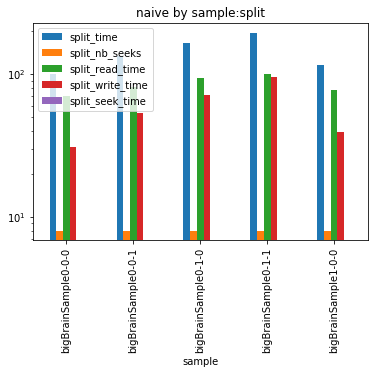

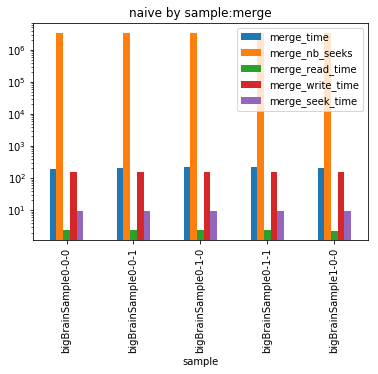

In [88]:
print_naive(hdd)